Tweets from disasters were analyzed using natural language processing a LSTM model.  The tweet data initially had 7613 tweets.  Duplicates were removed leading to 7503 unique tweets.  Cleaning converted the tweets to lowercase, removed a list of stop words, and stripped punctuation.  The model used tensorflow's text vectorizer, a LSTM layer, and 2 hidden dense layers.  Final training accuracy was 87% and test accuracy of 79%.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
df = pd.read_csv('../input/nlp-getting-started/train.csv')

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The dataset contains 7613 tweets.  The id, keyword, and location columns will not be used and missing values won't matter.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


There are 111 duplicate tweets.

In [5]:
df.text.drop_duplicates().shape

(7503,)

In [6]:
df = df.drop_duplicates(subset='text')
df.shape

(7503, 5)

The dataset is reasonably balanced with 3198 disaster tweets and 4305 non-disaster tweets.

In [7]:
df.target.value_counts()

0    4305
1    3198
Name: target, dtype: int64

The tweets contain up to 31 words with an average around 15.

31

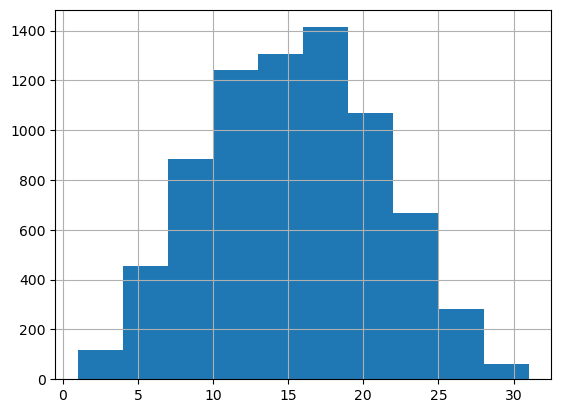

In [8]:
x = df.text.apply(str.split).apply(len)
x.hist()
plt.show
x.max()

Data is cleaned by converting to lower case and then removing a short list of stop words.

In [9]:
stop_words = [ 'stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'i', 'that', 'had', 'on', 'for', 'were', 'was', 'of', 'as', 'are'] # mostly from NLTK
df.text = df.text.str.lower()
df.text = df.text.apply(lambda x: " ".join(word for word in x.split(" ") if word not in stop_words))

In [10]:
df.text.head()

0    our deeds reason this #earthquake may allah fo...
1               forest fire near la ronge sask. canada
2    all residents asked 'shelter place' being noti...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska smo...
Name: text, dtype: object

Split into train and test sets using the pandas sample method with 20% hold out for test.

In [11]:
train = df.sample(frac=0.8, replace=False, random_state=42)
test = df.loc[df.index.drop(train.index)]
train.shape, test.shape

((6002, 5), (1501, 5))

Flatten everything to avoid shape errors in the sequential model.

In [12]:
X_train = train.text.values.flatten()
y_train = train.target.values.flatten()
X_test = test.text.values.flatten()
y_test = test.target.values.flatten()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6002,), (6002,), (1501,), (1501,))

In [13]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

Text is vectorized using the tensorflow TextVectorization which converts to lower and strips punctuation.  Experimented with output modes and ngrams.  Since it is a LSTM model output mode needs to be int.  Adding 2-grams gave no improvement.

In [14]:
tokens = 1500
encoder=TextVectorization(max_tokens=tokens, 
                          standardize='lower_and_strip_punctuation',
                          split='whitespace',
                          ngrams=None,
                          output_mode='int')
encoder.adapt(X_train)
callback=EarlyStopping(monitor='val_accuracy', patience = 3, restore_best_weights=False, start_from_epoch=5)

In [15]:
encoder.get_vocabulary()[:10]

['', '[UNK]', 'you', 'my', 'at', 'with', 'by', 'this', 'be', 'from']

Experimentation with model architectures gave minimal gains.

In [16]:
model = Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), mask_zero=True, output_dim = 50),
    LSTM(31, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 50)          75000     
                                                                 
 lstm (LSTM)                 (None, 31)                10168     
                                                                 
 dense (Dense)               (None, 25)                800       
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                        

In [17]:
history = model.fit(X_train, 
          y_train,
          batch_size=32,
          validation_data = (X_test, y_test),
          epochs=15,
          callbacks=[callback])

Epoch 1/15
188/188 [==============================] - 11s 30ms/step - loss: 0.6906 - accuracy: 0.5596 - val_loss: 0.6875 - val_accuracy: 0.5636
Epoch 2/15
188/188 [==============================] - 4s 21ms/step - loss: 0.6701 - accuracy: 0.6426 - val_loss: 0.6226 - val_accuracy: 0.7808
Epoch 3/15
188/188 [==============================] - 4s 21ms/step - loss: 0.5248 - accuracy: 0.7972 - val_loss: 0.4889 - val_accuracy: 0.7828
Epoch 4/15
188/188 [==============================] - 4s 21ms/step - loss: 0.4421 - accuracy: 0.8254 - val_loss: 0.4635 - val_accuracy: 0.7955
Epoch 5/15
188/188 [==============================] - 4s 21ms/step - loss: 0.4059 - accuracy: 0.8427 - val_loss: 0.4579 - val_accuracy: 0.7961
Epoch 6/15
188/188 [==============================] - 4s 22ms/step - loss: 0.3812 - accuracy: 0.8554 - val_loss: 0.4667 - val_accuracy: 0.7935
Epoch 7/15
188/188 [==============================] - 4s 21ms/step - loss: 0.3644 - accuracy: 0.8624 - val_loss: 0.4693 - val_accuracy: 0.794

Plot of validation accuracy and training accuracy.  In the second epoch (zero indexed in the plot) the validation accuracy is higher than the training accuracy, this is because validation is done at the end of epoch with after training while training is the average from the epoch.

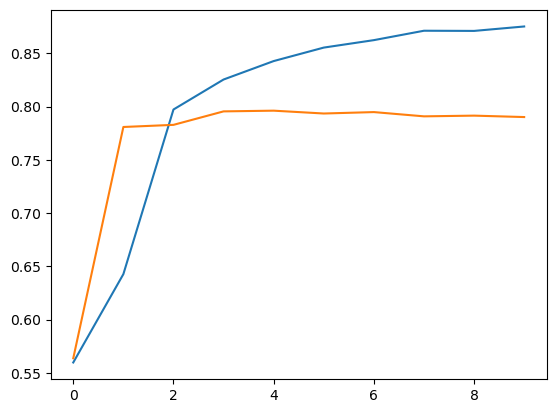

In [18]:
n = len(history.history['accuracy'])
plt.plot(range(n), history.history['accuracy'])
plt.plot(range(n), history.history['val_accuracy'])
plt.show()

Used this line to reset the model to best weights depending on the callback used.  Current callback doesn't reset weights and this does nothing.

In [19]:
best_model = history.model

Predictions for the submission set.

In [20]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
test_df.text = test_df.text.str.lower()
test_df.text = test_df.text.apply(lambda x: " ".join(word for word in x.split(" ") if word not in stop_words))
test = test_df.text.values.flatten()
test_df.shape, test.shape

((3263, 4), (3263,))

In [21]:
yhat = best_model.predict(test)

102/102 [==============================] - 2s 6ms/step


In [22]:
submission = test_df[['id']].copy()
submission['target'] = np.round(yhat,0)
submission.target = submission.target.astype(int)
submission.to_csv('submission.csv', index=False)

In [23]:
pd.read_csv('submission.csv').head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
